## IMPORTING LIBRARIES AND DATASET DOWNLOAD

In [1]:
%%capture
!pip install transformers
!pip install tensorflow-addons

In [2]:
#!pip install text_hammer
#import text_hammer as th
import re

# System Libraries
import os
from pathlib import Path
import tarfile
from IPython.display import Audio, clear_output
from tqdm import tqdm
from itertools import product
import pickle

# Handling Data Libraries
import pandas as pd
import numpy as np

# Plot Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
import librosa
import librosa.display

# ML libraries
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# DL libraries
import tensorflow as tf
import tensorflow_addons as tfa
import transformers
import keras
import keras as ks
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from keras import backend as K

EMO     = ['Anger', 'Happiness', 'Sadness', 'Neutral', 'Frustration', 'Excited', 'Fear', 'Surprise', 'Disgust', 'Other']
EMO_SIX = ['neu', 'fru', 'ang', 'sad', 'hap', 'exc']
VAD     = ['valence', 'activation', 'dominance']
TAG_ID  = ['session_id', 'conv_id', 'turn_id']

label2id = {'neu': 0, 'fru': 1, 'ang': 2, 'sad': 3, 'hap': 4, 'exc': 5, 'dis': 6, 'fea': 7, 'oth': 8, 'sur': 9, 'xxx': 10, 'pad': 11}

# Decide or not if you want to save the results on your drive by changing to True use_drive
from google.colab import drive
use_drive = True
if use_drive:
    drive_folder = os.path.join(os.getcwd(), 'gdrive')
    drive.mount(drive_folder)
    new_drive_folder = 'NLP_Models'
    models_folder = os.path.join(drive_folder, 'MyDrive', new_drive_folder)
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)
        print(f"{new_drive_folder} folder is created in your drive!")
else:
    models_folder = os.path.join(os.getcwd(), 'NLP_Models')
    os.makedirs(models_folder)
    print(f"{models_folder} folder is created!")

# Handling warnings library
'''
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
''';

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

The dataset is distributed on this webpage https://sail.usc.edu/iemocap/ under request, after the request is accepted they provide you a download link that expire in 48 hours therefore we uploaded a lighter copy of it on kaggle as a private dataset (only the files we were interested in), therefore to run the following cell you just have to ask the access to Riccardo Paolini, we will provide you the access as soon as possible, then you have to download a ***kaggle.json*** file from kaggle to do that follow this steps:
- go to https://www.kaggle.com/
- sign up/in to your account on kaggle
- click on your propic in the top right corner
- click "Your Profile -> Account -> Create New API Token"

after this steps the download of your ***kaggle.json*** file should have started.
By running the following cell you are requested to upload the ***kaggle.json*** therefore the download of the private dataset should start.

In [4]:
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle # Install kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d riccardopaolini/nlp-project-work
!unzip nlp-project-work.zip
clear_output()

## DATASET DESCRIPTION (Copy Paste of the README.txt file of the dataset)

Thank you for your interest in the USC_IEMOCAP database.  The USC_IEMOCAP database contains audio, transcriptions, video, and motion-capture(MoCap) recordings of dyadic mixed-gender pairs of actors.  There are five sessions in the database (ten actors total). For complete information about IEMOCAP please refer to:

Busso, Carlos et al.  "IEMOCAP: Interactive emotional dyadic motion capture database."  Journal of Language Resources and Evaluation.  Volume 42, Number 4.  pp. 335-359.  2008

as well as our website: http://sail.usc.edu/iemocap/

The recorded dialogs are either improvisations of affective scenarios, or performances of theatrical scripts. They have been manually segmented into utterances. Each utterance from either of the actors in the interaction has been evaluated categorically over the set of: {angry, happy, sad, neutral, frustrated, excited, fearful, surprised, disgusted, other} by at least three different annotators, and dimensionally over the axes of: valence (positive vs. negative); activation (calm vs. excited); and dominance (passive vs. aggressive) by at least two different annotators. 

In each recording of a session only one actor wears MoCap markers while both are being recorded by microphones and cameras. Thus there are available MoCap data (facial expression, head and hand movement) for one actor per recording, while there are wavefile and videos for both actors. The naming convention regarding the data is e.g., Ses01F_impro01 while indicates Session1, where the Female actor is wearing the markers and actors are performing improvisation 1. The release contains two formats: dialog format which contains data from the entire dyadic interaction and the sentence format where the data per dialog (recording) have been further segmented into utterances (see folders SessionX/dialog and SessionX/sentences respectively). For the utterance format the naming is as follows: Ses01F_impro01_M000 indicates first session, Female actor is wearing markers, actors are performing improvisation 1 and this is the first utterance of the Male actor. The timing of the sentences in each dialog can be found in the lab files in SessionX/dialog/lab

The MoCap data can be found in either dialog format or sentece format in the corresposding folders. The MOCAP_rotated folder contains motion-capture data rotated and translated such that the central nose marker always represents the (0,0,0) xyz-tuple. The MoCap data are in .txt files where each line is a frame number and each column is a marker coordinate. Please consult the headers of the MoCap files and the diagram of the facial markers (Documentation/FIVE_face_markers2.png) to see the correspondence between marker positions and marker names. The hand mocap data is in MOCAP_hand folder, while the information of head translation (x,y,z) and head rotation (yaw, pitch, roll) is in MOCAP_head folder. 

We are also distributing wavefiles (sentence and dialog format), the videos of the recordings (SessionX/dialog/avi/), and transcriptions of the dialogs (SessionX/dialog/transcriptions/). For the segmented utterances we are also providing the results of forced alignment which contain detail phoneme, syllable and word level timing information (SessionX/sentences/ForcedAlignment/).

The evaluations (emotional annotations) for each recording and each uterance are contained in folder SessionX/dialog/Evaluation/. Each file provides the detailed evaluation reports for the categorical evaluators (e.g., C-E1), the dimensional evaluators (e.g., A-E1), and the self-evaluatiors (e.g., C-F1 or C-M1, A-F1 or A-M1). The utterance-level information can be found in the first line of an utterance summary.  The first entry represents the start and end times for the utterance.  The second entry is the utterance name (e.g., Ses01_impro01_F003).  The third entry is the ground truth (if no majority ground truth could be assigned, the ground truth is labeled xxx).  The final engry is the average dimensional evaluation (over the evaluators, except the self-evaluators).

We are providing  a full release of this data in the hopes that it will provide a valuable resource to the emotion recognition community. We request that any published work using IEMOCAP should cite the paper entitled: "IEMOCAP: Interactive emotional dyadic motion capture database" (JLRE, 2008). If you do any further evaluation of the data, we request that you send us the detailed results so that we may provide a more detailed resource to the community. Also, please feel free to send us feedback regarding the database: how it is being used, if the information provided is sufficient, and how you have decided to utilize the evaluation information. Thanks again.


## BUILDING OF A DATAFRAME

In [4]:
folder = os.path.join(os.getcwd(), 'IEMOCAP')

conv_id = 0

df = []
for session in ['Session1','Session2','Session3','Session4','Session5']:
    session_path = os.path.join(folder, session)
    # 'dialogue' folder contains Emotions and Transcripts
    # 'sentences' folder contains Audios

    trans_folder = os.path.join(session_path, 'dialog', 'transcriptions')

    for trans_name in np.sort(os.listdir(trans_folder)):
        if trans_name[:2] != '._':
            emo_path = os.path.join(session_path, 'dialog', 'EmoEvaluation', trans_name)
            with open(os.path.join(trans_folder, trans_name), encoding='utf8') as trans_file, open(emo_path, encoding='utf8') as emo_file:
                conv_id += 1
                turn_id = 0
                for line in trans_file:
                    audio_name, text = line.split(':')
                    if trans_name.split('.')[0] in audio_name:
                        turn_id += 1

                        wav_path = os.path.join(session_path, 'sentences', 'wav', trans_name.split('.')[0], audio_name.split(' ')[0] + '.wav')

                        reached = False
                        count_em = {'Anger': 0, 'Happiness': 0, 'Sadness': 0, 'Neutral': 0, 'Frustration': 0, 'Excited': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Other': 0}
                        for emo_line in emo_file:
                            if audio_name.split(' ')[0] in emo_line:
                                emotion, vad = emo_line.split('\t')[-2:]
                                vad = vad[1:-2].split(',')
                                reached = True
                            elif emo_line[0] == 'C' and reached:
                                evaluator = emo_line.split(':')[0]
                                emotions = emo_line.split(':')[1].split('(')[0].split(';')
                                emotions = [em.strip() for em in emotions]
                                for em in emotions:
                                    if em != '':
                                        count_em[em] += 1
                            elif reached:
                                emo_file.seek(0)
                                break
                                    

                        row = {
                                'session_id': int(session[-1]),
                                'conv_id': conv_id, 
                                'turn_id': turn_id, 
                                'sentence': text.strip(),
                                'path': wav_path,
                                'emotion': emotion,
                                'valence': float(vad[0]),
                                'activation': float(vad[1]),
                                'dominance': float(vad[2])
                              }
                        
                        df.append(dict(**row, **count_em))

df = pd.DataFrame(df)

idx = np.array([os.path.exists(path) for path in df.path])
print(f'Missing Audios: {np.sum(~idx)}')
print('Missing Sentences:')
print(df.iloc[~idx,3])
df = df.iloc[idx, :]

Missing Audios: 48
Missing Sentences:
3854    [LAUGHTER], That's what they say.
3866                            Mmm, Hmm.
3880                                Yeah.
3898                               Kelly.
3915                           Yeah, man.
3939                      Uh-huh, uh-huh.
3961                              Uh-huh.
3968                                Yeah.
3972                                Yeah.
4010                       Well, I don't-
4044                                Yeah.
4827                        But, Listen--
4847                                Yeah.
4873                                Yeah.
4975                          We- I mean-
4991                                Okay.
5005                                Yeah.
5051                              Thanks.
5124                        to start off.
5181                                okay.
5192                                Okay.
5208                                Okay.
7893                                  

## DATA INSPECTION

### DATAFRAME INSPECTION

In [6]:
print(f'Dataframe shape: {df.shape}\n')
df.head()

Dataframe shape: (10039, 19)



,session_id,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other
0,1,1,1,Excuse me.,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,neu,2.5,2.5,2.5,0,0,0,4,0,0,0,0,0,0
1,1,1,2,Do you have your forms?,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,fru,2.5,2.0,2.5,0,0,0,1,3,0,0,0,0,1
2,1,1,3,Yeah.,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,neu,2.5,2.5,2.5,1,0,0,4,0,0,0,0,0,0
3,1,1,4,Let me see them.,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,fru,2.5,2.0,2.5,0,0,0,0,3,0,0,0,0,1
4,1,1,5,Is there a problem?,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,neu,2.5,2.5,2.5,1,0,0,3,0,0,0,1,0,0


In [5]:
df_turn_count = df.groupby(['session_id','conv_id'])['conv_id'].count().rename('turns').reset_index()
df_turn_count

,session_id,conv_id,turns
0,1,1,30
1,1,2,38
2,1,3,52
3,1,4,71
4,1,5,67
...,...,...,...
146,5,147,71
147,5,148,55
148,5,149,80
149,5,150,67


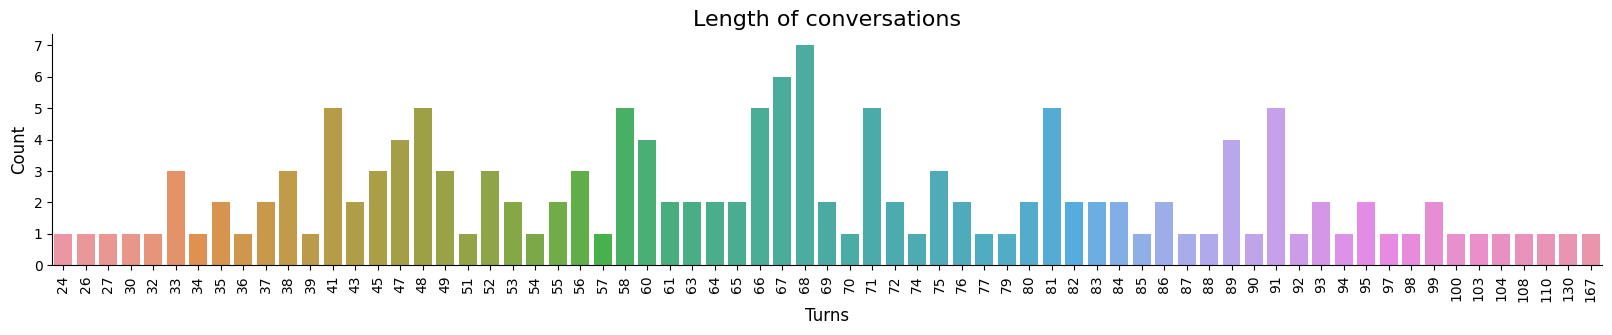

In [6]:
max_conv_length = df_turn_count['turns'].max()

plt.figure(figsize=(20, 3))
plt.title('Length of conversations', size=16)
sns.countplot(x=df_turn_count['turns'])

plt.ylabel('Count', size=12)
plt.xlabel('Turns', size=12)
plt.xticks(rotation = 90)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [7]:
df_conv_count = df_turn_count.groupby(['session_id'])['session_id'].count().rename('convs').reset_index()
df_conv_count

,session_id,convs
0,1,28
1,2,30
2,3,32
3,4,30
4,5,31


### AUDIO INSPECTION

In [ ]:
Audio(df.iloc[0, 4], autoplay=True) # ispection of the first audio (to change audio just change the first index)

### GOLDEN LABELS INSPECTION

In [10]:
print('EMOTIONS')
for em in np.unique(df.emotion):    
    print(f"  {em}: {np.sum(df.emotion == em)}")

EMOTIONS
  ang: 1108
  dis: 1
  exc: 1099
  fea: 35
  fru: 2040
  hap: 537
  neu: 1631
  oth: 3
  sad: 1079
  sur: 99
  xxx: 2407


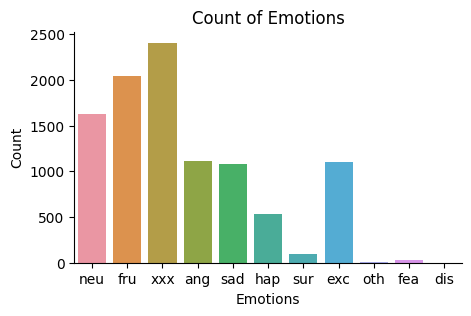

In [11]:
plt.figure(figsize=(5, 3))
plt.title('Count of Emotions')
sns.countplot(x=df['emotion'])

plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Let's do some consideration of the above plotted distribution of this golden labels:

- We can see how the emotion "xxx" is very common emotion (almost 2500 occurrences) but not very meaningful, our explanation behind the behavior of this golden label is that there isn't a predominant emotion in the classifications of the evaluators (excluding the self-evaluator) therefore an "xxx" gold label shows up.

- We can see that a lot of our labels are undersampled in comparison to the other labels, data augmentation could help in this cases

The strategies that we thinked of for handling the "xxx" labels are by considering them as missing values and trying to fill them by reconstruct a predominant emotion also considering the self-evaluators with more weights with respect to the other evaluators, but that would by definition modify the golden label we are provided with.

## VAD Inspection (Valence, Activation, Dominance)

In [ ]:
interactive = True # CHANGE THIS TO False IN ORDER TO SEE AN INTERACTIVE PLOT
title = "VAD Inspection with reference to golden labels"

if interactive:
    fig = px.scatter_3d(df, x='valence', y='activation', z='dominance',
                        color='emotion',
                        title=title)
    fig.show()
else:
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(15,10), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection = '3d')

    for e in df.emotion.unique():
        ax.scatter(df.valence[df.emotion == e], df.activation[df.emotion == e], df.dominance[df.emotion == e], label = e)

    ax.set_xlabel("valence")
    ax.set_ylabel("activation")
    ax.set_zlabel("dominance")

    ax.legend()

    plt.title(title)
    plt.show()

The only inspection for the VAD values that came in our mind is a visual inspection with reference to the golden labels and it seems that the golden labels are reflected in the VAD space with some clusters, that doesn't seem to be the case for the 'xxx' label that seems to be distributed quite randomly in this space.

## Audio Features Extraction and Data Augmentation

The feature extracted from the audio are:
- [zcr](https://librosa.org/doc/main/generated/librosa.feature.zero_crossing_rate.html): Zero Crossing Rate
- [chroma_stft](https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html): Power Spectrogram
- [mfcc](https://librosa.org/doc/main/generated/librosa.feature.mfcc.html): Mel-frequency cepstral coefficients
- [rms](https://librosa.org/doc/main/generated/librosa.feature.rms.html): Root Mean Square value
- [mel](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html): mel-scaled spectrogram

for each audio we create two new samples by slightly modifying the audio properties, the two augmentation technique adopted are:
- noising
- stretching & pitching

the transcription and the labels related to this augmented audios are the same of the non augmented counterparts

for each audio (augmented or not) we exctract the feaures described above and a new dataframe containing all this informations is created

therefore at the moment we have:

new_df.columns = \[session_id, conv_id, turn_id, augmentation, sentence, zcr, chroma_stft_0-chroma_stft_11, mfcc_0-mfcc_19, rms, mel_0-mel_127, emotion, valence, activation, dominance, Anger, Happiness, Sadness, Neutral, Frustration, Excited, Fear, Surprise, Disgust, Other\]

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
sample_rate = df['path'].apply(lambda x: librosa.get_samplerate(x)).min() # Audio will be automatically resampled to the given rate

def extract_features(df, sr=sample_rate):
    df_audio = {'session_id': [], 'conv_id': [], 'turn_id': [], 'mfcc': [], 'mel': [], 'chroma_stft': [], 'rms': [], 'zcr': []}
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], leave=False):
        audio, _ = librosa.load(row['path'], sr=sr)

        # Save info about the sample
        df_audio['session_id'].append(row['session_id'])
        df_audio['conv_id'].append(row['conv_id'])
        df_audio['turn_id'].append(row['turn_id'])

        # Mel-Frequency Cepstral Coefficients
        df_audio['mfcc'].append(librosa.feature.mfcc(y=audio, sr=sr).T)

        # Melspectrogram
        df_audio['mel'].append(librosa.feature.melspectrogram(y=audio, sr=sr).T)

        # Chromagram
        df_audio['chroma_stft'].append(librosa.feature.chroma_stft(y=audio, sr=sr).T)

        # Root-Mean-Square value
        df_audio['rms'].append(librosa.feature.rms(y=audio).T)

        # Zero-Crossing Rate
        df_audio['zcr'].append(librosa.feature.zero_crossing_rate(y=audio).T)

    return pd.DataFrame(df_audio)

df_audio = extract_features(df)

In [ ]:
# Save audio features
save_path = 'audio_features.pkl'
df_audio.to_pickle(save_path)

In [8]:
# Features to load -> {'mfcc', 'mel', 'chroma_stft', 'rms', 'zcr'}
audio_feats = ['mfcc']

In [9]:
# Load selected features
df_audio = pd.read_pickle('gdrive/MyDrive/audio_features.pkl')[TAG_ID + audio_feats]

In [10]:
standardize = lambda x: (x - x.mean(axis=0)) / x.std(axis=0)
normalize = lambda x: (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))

def normalize_and_reshape(array, perc):
    #array = standardize(array)
    array = normalize(array)
    if int(perc) <= array.shape[0]:
        return array[:int(perc)]
    else:
        aux_array = np.array([[0] * array.shape[1]] * (int(perc) - array.shape[0]))
        return np.concatenate([aux_array, array], axis=0)

def process_features(df, feat_list, perc=0.95):
    df_proc = df.copy()
    for feat in feat_list:
        df_proc[feat] = df_proc[feat].apply(lambda x: np.array(x))
        perc_val = df_proc[feat].apply(lambda x: x.shape[0]).quantile(perc)
        df_proc[feat] = df_proc[feat].apply(lambda x: normalize_and_reshape(x, perc_val))

    return df_proc

In [11]:
df_audio = process_features(df_audio, audio_feats, perc=0.75)

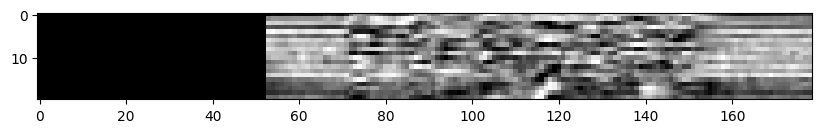

In [12]:
plt.figure(figsize=(10,10))
num_plots = len(audio_feats)
for idx, feat in enumerate(audio_feats):
    plt.subplot(1, num_plots, idx+1)
    plt.imshow(df_audio[feat][9].T, cmap='gray')
plt.show()

In [12]:
columns = TAG_ID + ['sentence', 'emotion']
df_full = df[columns].merge(df_audio, on=TAG_ID)
del df_audio
df_full

,session_id,conv_id,turn_id,sentence,emotion,mfcc
0,1,1,1,Excuse me.,neu,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,2,Do you have your forms?,fru,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,1,3,Yeah.,neu,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,1,4,Let me see them.,fru,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,1,5,Is there a problem?,neu,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...
10034,5,151,87,oh! Marry you again? I wouldn't marry you agai...,ang,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
10035,5,151,88,Beast,ang,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
10036,5,151,89,You're a wicked little vampire. And I pray to...,ang,"[[0.16109523, 0.029401563, 1.0, 0.89426804, 0...."
10037,5,151,90,Brute,ang,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Padding Conversations

Each conversation have a length in term of turns, here we pad the conversation that are shorter than the maximum conversation length in our dataset (that is 167), basically we are adding turns that aren't real, by doing that we have that all the conversation have a specific length in term of turns.
for the turns that aren't real we fill the features of the dataframe in this way:
- sentence: the transcription of the non real audio is the empty string ''
- audio features: all the audio features exctracted are setted to 0.0
- emotion: we add a new label to the dataset that is the label 'pad' (useful for trying to ignore that both in training and in the other metrics like we did in assignment 1)
- vad labels: all this labels are setted to 0.0 (we have to double check if we are trying to use them but for now they are setted in this way for laziness given that we are not using them)
- multilabels: we are adding a feature called 'Pad' to the dataframe and give a count of 1 to this feature, all the other multilabel features have count of 0 

In [13]:
df_pad = pd.DataFrame(data=list(product(df_full.conv_id.unique(), np.arange(1, max_conv_length+1))),columns=['conv_id', 'turn_id'])
df_pad = pd.merge(df_full, df_pad, how='right', on=['conv_id', 'turn_id'])

#multilabels = ['Anger',	'Happiness',	'Sadness',	'Neutral',	'Frustration',	'Excited',	'Fear',	'Surprise',	'Disgust',	'Other']

conv_to_session = {c: s for s, c in zip(df_turn_count['session_id'], df_turn_count['conv_id'])}

# Fill NaN
df_pad['session_id'] = df_pad['conv_id'].apply(lambda c: conv_to_session[c])
df_pad['sentence']   = df_pad['sentence'].fillna('')
df_pad['emotion']    = df_pad['emotion'].fillna('pad')

# Fill NaN (Audio features)
for feat in audio_feats:
  shape = df_pad[feat][0].shape
  df_pad[feat] = df_pad[feat].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(shape))

df_pad[df_pad.conv_id == 1] # conv_id 97 is the longest conversation

,session_id,conv_id,turn_id,sentence,emotion,mfcc
0,1,1,1,Excuse me.,neu,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,2,Do you have your forms?,fru,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,1,3,Yeah.,neu,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,1,4,Let me see them.,fru,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,1,5,Is there a problem?,neu,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...
162,1,1,163,,pad,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
163,1,1,164,,pad,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
164,1,1,165,,pad,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
165,1,1,166,,pad,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
def text_preprocessing(data, column):
  df = data.copy()
  df[column] = df[column].apply(lambda x: str(x).lower())
  #df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're --> you are
  #df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  #df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
  df[column] = df[column].apply(lambda x: re.sub(r'\d', "number", x))
  df[column] = df[column].apply(lambda x: re.sub("_", "number", x))
  return df

df_proc = text_preprocessing(df_pad, 'sentence')
df_proc[df_proc['conv_id'] == 1]

,session_id,conv_id,turn_id,sentence,emotion,mfcc
0,1,1,1,excuse me.,neu,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,2,do you have your forms?,fru,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,1,3,yeah.,neu,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,1,4,let me see them.,fru,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,1,5,is there a problem?,neu,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...
162,1,1,163,,pad,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
163,1,1,164,,pad,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
164,1,1,165,,pad,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
165,1,1,166,,pad,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [32]:
model_name = 'prajjwal1/bert-tiny'

# IMPORT TOKENIZER
tokenizer_bert = transformers.AutoTokenizer.from_pretrained(model_name)
clear_output()

In [25]:
def tokenize(sentences, tokenizer):
    input_ids = []
    attention_mask = []
    for sentence in sentences:
        token_list = tokenizer(sentence, max_length=512, padding='max_length', truncation=True)
        input_ids.append(token_list.input_ids)
        attention_mask.append(token_list.attention_mask)
    return np.array(input_ids), np.array(attention_mask)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Creating tokenizer and fitting it on the training test
tokenizer = Tokenizer(num_words = None, oov_token='[UNK]', split=' ', lower=False)
tokenizer.fit_on_texts(df_proc['sentence'])

# Printing a tokenization example
n = 3
print("## Before tokenization: ")
print(df_proc['sentence'][n])
print("\n## After tokenization: ")
print(tokenizer.texts_to_sequences(df_proc['sentence'])[n])

## Build data for our model

Here we can decide the data we want to exctract for training and evaluate our model, if we want we can exctract also the original data without augmentation and padding. for doing that just exctract the information you want from the dataframe and put them into numpy arrays.

the data exctracted for the following model are:
- augmented and padded data for training.
- non augmented and padded data for validation and testing.

The reason behind this choice is that training on augmented data could help the model to learn, but the validation and test data are not augmented because we want to evaluate our model on the original data, the fact that we pad the conversation shouldn't be a problem because we can specify to our metric to ignore the 'pad' labels therefore we can get consistent results.

When we say that we use augmented data we mean that we use the data with augmentation 'none' to build a conversation, the data with augmentation 'noise' to build the same conversation but this conversation is all noisy, and we do the same for a new conversation all streched and pitched. in fact we can notice that the first dimension of the train_data is 270 that is 90 * 3 where 90 is the number of conversations we have in the original data and 3 is the number of augmentations techniques used.

We can easily extend the conversations by combining the augmentation techniques in different ways, for example we create a conversation were the male actor is talking noisy and the female actor is talking normally, or we can noise a part of the audios from the male actor and the other audios of the male actor are normal (and here we are just talking on combinations of 'none' and 'noise' augmentations only but we have also 'stretch and pitch')

also notice that we don't standardize our data before feeding it into the model and the reason behind this choice is due to the padding of the conversations.
Given that we pad the conversations we have also to mask the added audios, and we mask them thanks to the masking layer that masks all the inputs that are 0.0.
If we had standardized the data we would have lost the correspondence between the value 0 and the padded data.

In [33]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_sentence_length = 33

# DATA SPLITTING
df_train  = df_pad[df_pad.session_id <= 3]
df_val    = df_pad[df_pad.session_id == 4]
df_test   = df_pad[df_pad.session_id == 5]

# PREPARE AUDIOS
audio_train = np.array([np.concatenate([row[col] for col in audio_feats], axis=-1) for _, row in df_train.iterrows()])
audio_val   = np.array([np.concatenate([row[col] for col in audio_feats], axis=-1) for _, row in df_val.iterrows()])
audio_test  = np.array([np.concatenate([row[col] for col in audio_feats], axis=-1) for _, row in df_test.iterrows()])

# PREPARE TEXTS
text_train_ids, text_train_mask = tokenize(df_train['sentence'].tolist(), tokenizer_bert)
text_val_ids, text_val_mask     = tokenize(df_val['sentence'].tolist(), tokenizer_bert)
text_test_ids, text_test_mask   = tokenize(df_test['sentence'].tolist(), tokenizer_bert)

# tokenization_args = {'truncating': 'post', 'padding': 'post', 'maxlen': max_sentence_length}
# text_train  = np.array(pad_sequences(tokenizer.texts_to_sequences(df_train['sentence']), **tokenization_args))
# text_val    = np.array(pad_sequences(tokenizer.texts_to_sequences(df_val['sentence']),   **tokenization_args))
# text_test   = np.array(pad_sequences(tokenizer.texts_to_sequences(df_test['sentence']),  **tokenization_args))

# PREPARE LABELS
em_train    = ks.utils.to_categorical(df_train['emotion'].map(label2id),  num_classes=12)
em_val      = ks.utils.to_categorical(df_val['emotion'].map(label2id),    num_classes=12)
em_test     = ks.utils.to_categorical(df_test['emotion'].map(label2id),   num_classes=12)

# MAKE DATA COMPATIBLE WITH RECURRENT MODEL
text_train_ids  = text_train_ids.reshape((df_conv_count['convs'][:3].sum(), max_conv_length, text_train_ids.shape[1]))
text_train_mask = text_train_mask.reshape((df_conv_count['convs'][:3].sum(), max_conv_length, text_train_mask.shape[1]))

text_val_ids    = text_val_ids.reshape((df_conv_count['convs'][3].sum(), max_conv_length, text_val_ids.shape[1]))
text_val_mask   = text_val_mask.reshape((df_conv_count['convs'][3].sum(), max_conv_length, text_val_mask.shape[1]))

text_test_ids   = text_test_ids.reshape((df_conv_count['convs'][4].sum(), max_conv_length, text_test_ids.shape[1]))
text_test_mask  = text_test_mask.reshape((df_conv_count['convs'][4].sum(), max_conv_length, text_test_mask.shape[1]))

audio_train = audio_train.reshape((df_conv_count['convs'][:3].sum(), max_conv_length, audio_train.shape[1], audio_train.shape[2]))
audio_val   = audio_val.reshape((df_conv_count['convs'][3].sum(), max_conv_length, audio_val.shape[1], audio_val.shape[2]))
audio_test  = audio_test.reshape((df_conv_count['convs'][4].sum(), max_conv_length, audio_test.shape[1], audio_test.shape[2]))

em_train  = em_train.reshape((df_conv_count['convs'][:3].sum(), max_conv_length, em_train.shape[1]))
em_val    = em_val.reshape((df_conv_count['convs'][3].sum(), max_conv_length, em_val.shape[1]))
em_test   = em_test.reshape((df_conv_count['convs'][4].sum(), max_conv_length, em_test.shape[1]))

print('Shapes:')
print(f'\t-audio_train : {audio_train.shape}\t-text_train : {text_train_ids.shape}\t-em_train : {em_train.shape}')
print(f'\t-audio_val   : {audio_val.shape}\t-text_val   : {text_val_ids.shape}\t-em_val   : {em_val.shape}')
print(f'\t-audio_test  : {audio_test.shape}\t-text_test  : {text_test_ids.shape}\t-em_test  : {em_test.shape}')

Shapes:
	-audio_train : (90, 167, 179, 20)	-text_train : (90, 167, 512)	-em_train : (90, 167, 12)
	-audio_val   : (30, 167, 179, 20)	-text_val   : (30, 167, 512)	-em_val   : (30, 167, 12)
	-audio_test  : (31, 167, 179, 20)	-text_test  : (31, 167, 512)	-em_test  : (31, 167, 12)


## Model Definition

The model is thinked to take into account conversations in the batch dimension and not the turns.

Below is showed a visual representation of the CNN_on_Feature_Cell class that is the big box, the inputs for that class are given by the RNN wrapper class of tensorflow that can take as input also Custom Cells

<img src='https://drive.google.com/uc?id=1aBHLPX74TcdVJP1zYMYp_1t8o5dpfbPr'>

the audio embedding take inputs of dimensions (162,1) because 162 are the features exctracted from the audios and the last dimension is used to apply Conv1D of keras (that are present inside the audio embedding).

The audio embedding output can be a vector of arbitrary dimension that is concatenated to the state (who's dimension can be specified as an hyperparameter).

The concatenation is then passed as an input to two dense layers, one that specifies the new state and one that specifies the output (who's dimension can be specified as an hyperparameter)

now i will describe the full model:

- what we expect in input to our model is the conversations padded, each audio in the conversation have the 162 features pre-processed (X_1 are the features extracted from the first audio of the conversation)

- first we mask the input to tell the model what to ignore

- then we reshape the input to make it suitable for the convolutions

- then we pass the input masked and reshaped to the designed cell thanks to the RNN wrapper. Each output of the cell represent an embedding that take in consideration both X_t and S_t-1 (in practice Y_1 for example takes into account X_1 and S_0 that is full of zeros, then Y_2 takes into account X_2 and S_1 that mantains memory of the past audios)

- then we take all the Y produced and we apply a dense layer which produce an output of 32 units followed by a dropout for all the Y (that means for each turn of the conversation)

- then for each turn of the conversation we have an output of 12 because we have 11 emotions and the pad class


The problem of this model is that most likely he suffers the vanishing gradient problem (look at the history plot below), the next step will be trying to use a GRU or LSTM as a wrapper for the cell, this has to be investigated.

The results are saved on my drive and can be loaded at any time given that i setted the variables use_drive=True and override_cnn_on_features=True

NB: BELOW YOU WILL FIND COMMENTS I'M STILL WORKING ON IT

UPDATE! 
- I moved the audio embedder outside of the cell and used a time distributed wrapper on it, then i substituted the remaining part of the cell in the upper figure with a GRU layer, that should suffice in keeping track of the past history of the embedded audios, in this way the model description should be more clear also at code level.

- The model wasn't taking into account the masked input in the computation of the loss. the mask was used only in order to speed up the computation of the model. therefore i keeped the mask and also added the sample_weights parameters, the results are more likely to be correct, the high score of the previous version were due to the fact that i was considering also the 'pad' labels.

In [42]:
class Masked_Categorical_Crossentropy():
    def __init__(self, ignore_indexes = []):
        self.ignore_indexes = ignore_indexes
        self.loss = tf.keras.losses.CategoricalCrossentropy(reduction='none')
    
    def __call__(self, label, pred):
        loss = self.loss(label, pred)
        label = tf.argmax(label, axis=-1)
        mask = tf.cast(tf.zeros_like(label), dtype='bool')
        for idx in self.ignore_indexes:
            mask = mask | (label != idx)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss)/tf.reduce_sum(mask)

class Masked_Categorical_Accuracy():
    def __init__(self, ignore_indexes = []):
        self.ignore_indexes = ignore_indexes

    def __call__(self, label, pred):
        pred = tf.argmax(pred, axis=-1)
        label = tf.cast(tf.argmax(label, axis=-1), pred.dtype)
        good = label == pred

        mask = tf.cast(tf.zeros_like(good), dtype='bool')
        for idx in self.ignore_indexes:
            mask = mask | (label != idx)
        
        good = good & mask
        good = tf.cast(good, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(good)/tf.reduce_sum(mask)

class Masked_F1():
    def __init__(self, mode='macro', ignore_indexes = [], name=None, dataset_distribution=None):
        # mode='weighted' and dataset_distribution=None is equivalent to mode='macro'
        self.ignore_indexes = ignore_indexes
        self.loss = tf.keras.losses.CategoricalCrossentropy(reduction='none')
        self.mode = mode
        self.dataset_distribution = dataset_distribution
        if name is not None:
            self.__name__ = name

    def set_split_params(self, dataset_distribution):
        # the distribution changes continuously when fit is called (is setted to train and val thanks to ChangeTrainValBehaviour custom Callback)
        self.dataset_distribution = dataset_distribution
    
    def __call__(self, label, pred):

        batch_size = tf.size(label) / np.prod(label.shape[1:])
        shape = (batch_size, *label.shape[1:])

        if len(label.shape) >= 3:
            label = K.reshape(label, (batch_size * np.prod(label.shape[1:-1]),label.shape[-1]))
            pred = K.reshape(pred, (batch_size * np.prod(pred.shape[1:-1]),pred.shape[-1]))
        
        pred = K.cast(K.equal(pred, K.max(pred, axis=1, keepdims=True)), tf.float32)

        tp = K.sum(K.cast(label*pred, 'float'), axis=0)
        fp = K.sum(K.cast((1-label)*pred, 'float'), axis=0)
        fn = K.sum(K.cast(label*(1-pred), 'float'), axis=0)

        f1 = 2*tp / (2*tp+fn+fp+K.epsilon())

        mask = tf.cast(tf.ones_like(f1), dtype='bool')
        for idx in self.ignore_indexes:
            mask = mask & (tf.convert_to_tensor(np.arange(label.shape[-1])) != idx)
        mask = tf.cast(mask, dtype=tf.float32)

        f1 *= mask

        if self.dataset_distribution is None:
            dataset_distribution = tf.ones_like(f1) / K.sum(mask)
        else:
            dataset_distribution = tf.convert_to_tensor(self.dataset_distribution, dtype=tf.float32) * mask
            dataset_distribution /= K.sum(dataset_distribution)

        if self.mode == 'none':
            return f1
        if self.mode == 'macro':
            return K.sum(f1)/K.sum(mask)
        if self.mode == 'weighted':
            return K.sum(f1 * dataset_distribution)

In [ ]:
text_embedder = ks.models.Sequential([
            ks.layers.Embedding(tokenizer.document_count, 64, input_length=text_shape[-1]),
            ks.layers.Bidirectional(ks.layers.LSTM(64, return_sequences=True)),
            ks.layers.Bidirectional(ks.layers.LSTM(64))
])
text_embedder.summary()

In [ ]:
audio_embedder = ks.Sequential([
            ks.layers.LSTM(64, dropout=0.0)
])
audio_embedder.summary()

In [58]:
def get_model(text_shape, audio_shape, num_classes, lstm_units):

    ############################# CREATING LAYERS ##############################
    # TEXT EMBEDDER
    # text_embedder = ks.models.Sequential([
    #         ks.layers.Embedding(tokenizer.document_count, 64, input_length=text_shape[-1]),
    #         ks.layers.Bidirectional(ks.layers.LSTM(64, return_sequences=True)),
    #         ks.layers.Bidirectional(ks.layers.LSTM(64))
    # ])
    
    text_embedder = transformers.TFAutoModel.from_pretrained(model_name, from_pt=True)

    # AUDIO EMBEDDER
    audio_embedder = ks.Sequential([
            ks.layers.LSTM(64, dropout=0.0)
    ])

    # EMBEDDERS - TIME DISTRIBUTED
    time_text     = ks.layers.TimeDistributed(text_embedder,  name='time_text_embedder')
    time_audio    = ks.layers.TimeDistributed(audio_embedder, name='time_audio_embedder')

    # FINAL LAYERS - TIME DISTRIBUTED
    time_dense    = ks.layers.TimeDistributed(Dense(32, activation='relu'), name='time_dense')
    time_dropout  = ks.layers.TimeDistributed(Dropout(0.3), name = 'time_dropout')
    time_logits   = ks.layers.TimeDistributed(Dense(num_classes, activation='softmax'), name='time_probs')

    ############################## JOINING LAYERS ##############################
    # TEXT NETWORK
    text_input_ids  = ks.layers.Input(text_shape, name='text_ids', dtype=np.int32)
    text_input_mask = ks.layers.Input(text_shape, name='text_mask', dtype=np.int32)
    text_emb = time_text([text_input_ids, text_input_mask])['last_hidden_state']
    text_emb = tf.reduce_mean(text_emb, axis=-2)
    text_emb = ks.layers.Dense(64)(text_emb)

    # AUDIO NETWORK
    audio_input = ks.layers.Input(audio_shape, name='audio_input', dtype=np.float16)
    audio_mask  = ks.layers.Masking(mask_value=0.0)(audio_input)
    audio_emb   = time_audio(audio_mask)

    # JOIN EMBEDDINGS
    emb = ks.layers.concatenate([text_emb, audio_emb], axis=-1)

    # MEMORY STATE
    x = ks.layers.LSTM(lstm_units, return_sequences=True)(emb)
    x = time_dense(x)
    x = time_dropout(x)
    output = time_logits(x)

    model = keras.models.Model([text_input_ids, text_input_mask, audio_input], output)

    return model

model = get_model(
                  text_shape=text_train_ids.shape[1:], 
                  audio_shape=audio_train.shape[1:], 
                  num_classes=12,
                  lstm_units=64
                  )

clear_output()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_ids (InputLayer)          [(None, 167, 512)]   0           []                               
                                                                                                  
 text_mask (InputLayer)         [(None, 167, 512)]   0           []                               
                                                                                                  
 time_text_embedder (TimeDistri  TFBaseModelOutputWi  4385920    ['text_ids[0][0]',               
 buted)                         thPoolingAndCrossAt               'text_mask[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 167,                                         

In [ ]:
ks.utils.plot_model(model, show_shapes=True, dpi=60)

In [56]:
# COMPILATION PARAMETERS
optimizer = ks.optimizers.Adam(1e-2)

loss = Masked_Categorical_Crossentropy(ignore_indexes = [label2id['pad']])

metrics = [
    Masked_Categorical_Accuracy(ignore_indexes = [label2id['pad']]),
    Masked_F1(mode='macro', ignore_indexes = [label2id['pad']])
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [57]:
# MODEL TRAINING
save_checkpoint = True
checkpoint_path = os.path.join(models_folder, "Multimodal_Model_v0.h5")

callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=1e-6)]
if save_checkpoint:
    callbacks += [ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor="val_loss")]

#history=model.fit([X_train, X_train_text], y_train, sample_weight=sample_w_train, batch_size=batch_size, epochs=50, validation_data=([X_val, X_val_text], y_val, sample_w_val), callbacks=callbacks)
history=model.fit([text_train_ids, text_train_mask, audio_train], em_train, batch_size=1, epochs=20, validation_data=([text_val_ids, text_val_mask, audio_val], em_val), callbacks=callbacks)

Epoch 1/20


90/90 [==============================] - 67s 580ms/step - loss: 2.1500 - masked__categorical__accuracy: 0.1916 - masked_f1: 0.0290 - val_loss: 1.8848 - val_masked__categorical__accuracy: 0.2287 - val_masked_f1: 0.0292 - lr: 0.0100
Epoch 2/20
90/90 [==============================] - 49s 547ms/step - loss: 1.9825 - masked__categorical__accuracy: 0.2227 - masked_f1: 0.0243 - val_loss: 1.8949 - val_masked__categorical__accuracy: 0.2682 - val_masked_f1: 0.0211 - lr: 0.0100
Epoch 3/20
90/90 [==============================] - 48s 539ms/step - loss: 1.9601 - masked__categorical__accuracy: 0.2345 - masked_f1: 0.0196 - val_loss: 1.9092 - val_masked__categorical__accuracy: 0.2682 - val_masked_f1: 0.0211 - lr: 0.0100
Epoch 4/20
90/90 [==============================] - 49s 544ms/step - loss: 1.9537 - masked__categorical__accuracy: 0.2412 - masked_f1: 0.0182 - val_loss: 1.9096 - val_masked__categorical__accuracy: 0.2287 - val_masked_f1: 0.0292 - lr: 0.0100
Epoch 5/20
90/90 [=========================

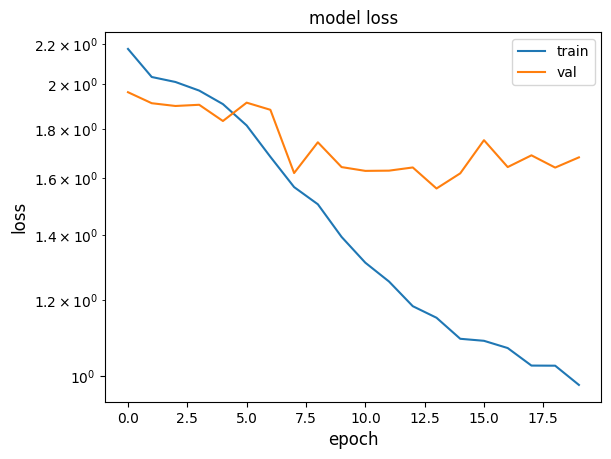

In [40]:
metric = "loss"

plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])

plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.yscale('log')

plt.show()

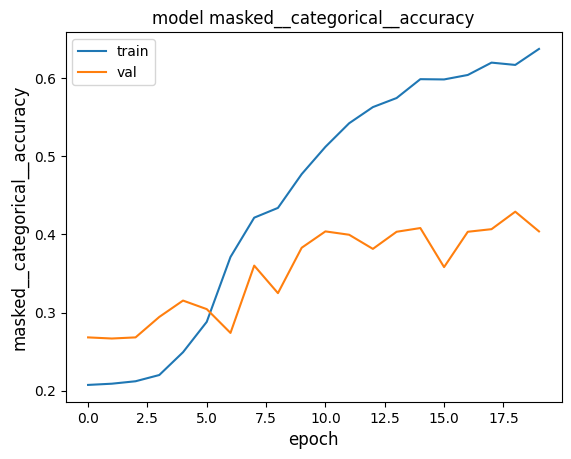

In [41]:
metric = "masked__categorical__accuracy"

plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])

plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")

plt.show()